<a href="https://colab.research.google.com/github/raynardj/python4ml/blob/master/experiments/gan/ACGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auxiliary Classifier GANs

In [0]:
from torchvision.datasets import CIFAR100

### CIFAR 100 dataset

In [0]:
# !pip install git+https://github.com/raynardj/forge

In [0]:
# from forgebox.ftorch.tracker import FG
# fg = FG("ACGAN")

In [0]:
from torchvision import transforms as TR

In [0]:
transforms = TR.Compose([

        TR.ToTensor(),
#         TR.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

In [0]:
DOWNLOAD = False

In [12]:
train_ds = CIFAR100("data",train = True, transform = transforms, download=DOWNLOAD)
valid_ds = CIFAR100("data",train = False, transform = transforms, download=DOWNLOAD)

  0%|          | 0/169001437 [00:00<?, ?it/s]

100%|█████████▉| 168845312/169001437 [00:30<00:00, 3993536.38it/s]

Files already downloaded and verified


In [13]:
len(train_ds), len(valid_ds)

(50000, 10000)

In [0]:
from forgebox.ftorch.prepro import test_DS

In [15]:
x,y  = test_DS(train_ds)()
x.max(), x.min(), x.size()

(tensor(1.), tensor(0.0039), torch.Size([1, 3, 32, 32]))

In [0]:
from torch import nn
import torch
from torch.utils.data import DataLoader

In [0]:
CUDA = torch.cuda.is_available()

In [0]:

import numpy as np

In [0]:
def conv_layer(in_,out,ks=3,padding=None,bn=False, act=True):
    convs = [
        nn.Conv2d(in_,out, 
                kernel_size=3, 
                padding=ks//2 if padding== None else padding, 
                bias=False if bn else True,),
            ]
    if bn: convs.append(nn.BatchNorm2d(out,))
    if act: convs.append(nn.ReLU())
    return nn.Sequential(*convs)

class res_block(nn.Module):
    def __init__(self, in_,ks=3, hs=None, bn = False):
        super().__init__()
        in_ = in_
        hs = hs if hs else in_
        self.convs = nn.Sequential(*[
            conv_layer(in_, hs, bn = True, ),
            conv_layer(hs, in_, bn = True, ),
        ])
    
    def forward(self,x):
        return x + self.convs(x)
        
class G(nn.Module):
    def __init__(self, in_,classes = 100):
        super().__init__()
        self.in_ = in_//2
        self.classes = classes
        self.emb = nn.Embedding(100,in_-self.in_)
        self.start = nn.Linear(in_,1*32*32)
        self.conv_blocks = nn.Sequential(*[
            conv_layer(1,32),
            res_block(32),conv_layer(32,64),
            res_block(64),conv_layer(64,32),
            conv_layer(32,3, act= False, bn = False),
        ])        
    def forward(self,x, class_idx):
        bs = x.size()[0]
        x1 = self.emb(class_idx)
        x = torch.cat([x,x1],dim=-1)
        x = self.start(x)
        x = torch.reshape(x,(bs,1,32,32))
        x = self.conv_blocks(x)
        return torch.sigmoid(x)
    
    def new_images(self, number,):
        x = torch.rand(number,self.in_)
        class_idx = torch.LongTensor(np.random.choice(np.arange(100),size=number))
        if CUDA: x=x.cuda();class_idx=class_idx.cuda()
        x = self.forward(x,class_idx)
        return x, class_idx
    
class D(nn.Module):
    def __init__(self, classes = 100):
        super().__init__()
        self.classes = classes
        self.conv_blocks = nn.Sequential(*[
            conv_layer(3,32),res_block(32),nn.AvgPool2d((2,2)),
            conv_layer(32,64),res_block(64),nn.AvgPool2d((2,2)),
            conv_layer(64,32,act=False, bn=False),
        ])
        self.fcb=nn.Sequential(*[
            nn.Linear(8*8*32,512,bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512,1+self.classes,bias=False)
        ])
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self,x):
        x = self.conv_blocks(x)
        bs = x.size()[0]
        x = torch.reshape(x,(bs,8*8*32))
        x = self.fcb(x)
        x_1 = x[:,:1]
        x_2 = self.softmax(x[:,1:])
        return x_1,x_2

In [20]:
d = D()

a = torch.rand(32,3,32,32)
d(a)

(tensor([[ 0.1877],
         [ 0.2148],
         [ 0.2741],
         [ 0.0359],
         [ 0.0018],
         [ 0.2083],
         [-0.0496],
         [ 0.0258],
         [ 0.0907],
         [ 0.2273],
         [ 0.2185],
         [-0.0373],
         [-0.1715],
         [ 0.1424],
         [-0.0399],
         [ 0.3953],
         [-0.1006],
         [ 0.1419],
         [-0.2327],
         [ 0.1748],
         [-0.0076],
         [-0.1690],
         [ 0.0749],
         [ 0.2266],
         [-0.3222],
         [ 0.1761],
         [-0.1626],
         [ 0.0839],
         [ 0.1114],
         [-0.0493],
         [ 0.1846],
         [ 0.0656]], grad_fn=<SliceBackward>),
 tensor([[0.0071, 0.0108, 0.0102,  ..., 0.0070, 0.0072, 0.0112],
         [0.0081, 0.0096, 0.0085,  ..., 0.0089, 0.0073, 0.0107],
         [0.0129, 0.0113, 0.0059,  ..., 0.0080, 0.0126, 0.0066],
         ...,
         [0.0093, 0.0133, 0.0070,  ..., 0.0094, 0.0078, 0.0091],
         [0.0104, 0.0143, 0.0085,  ..., 0.0080, 0.0102, 0.0

### Training

In [0]:
from forgebox.ftorch.train import Trainer
from forgebox.ftorch.callbacks import stat

from torch.optim import Adam, RMSprop

celoss = nn.CrossEntropyLoss()

In [0]:
trainer = Trainer(dataset=train_ds, batch_size=32, print_on=5, callbacks=[stat])

In [0]:
g,d = G(100,classes=100),D(classes=100)
if CUDA:
    g,d = g.cuda(),d.cuda()
opt_G = RMSprop(g.parameters(),lr= 5e-5)
opt_D = RMSprop(d.parameters(),lr= 5e-5)

trainer.train_G = True
trainer.loss_G = 0
trainer.loss_D = 0
@trainer.step_train
def action(batch):
    if batch.i %6 ==5:
        trainer.train_G = True
    else:
        trainer.train_G = False
    opt_G.zero_grad()
    opt_D.zero_grad()
    
    real,y = batch.data
    
    bs = real.size()[0]
    z = torch.rand(bs, 50)
    
    if CUDA:
        real = real.cuda()
        y = y.cuda()
        z = z.cuda()
    fake = g(z,y)
    x = torch.cat([real,fake], dim=0)
    y_all = torch.cat([y,y],dim=-1)
    if trainer.train_G:
        
        gan_pred,cls_pred = d(fake)
        gan_loss = -gan_pred.mean()
        cls_loss = celoss(cls_pred,y)
        loss = gan_loss + cls_loss*1e-3
        trainer.loss_G = gan_loss.item()
        loss.backward()
        opt_G.step()
    else:
        gan_pred_r,cls_pred_r = d(real)
        gan_pred_f,cls_pred_f = d(fake)
        gan_loss = -(gan_pred_r.mean() - gan_pred_f.mean())
        cls_loss = celoss(torch.cat([cls_pred_r,cls_pred_f],dim=0),y_all)
        loss = gan_loss+cls_loss*1e-3
        trainer.loss_D = gan_loss.item()
        loss.backward()
        opt_D.step()
        for p in d.parameters():
            p.data.clamp_(-1e-2, 1e-2)
    return {"loss":loss.item(),"g":trainer.loss_G, "d":trainer.loss_D, "cls":cls_loss.item()}

In [31]:
trainer.train(50)

,cls,d,epoch,g,iter,loss,timestamp
mean,4.605170,-0.003386,0.0,0.001248,781.0,0.002013,0.028573
min,4.604933,-0.010607,0.0,-0.004815,0.0,-0.006002,0.000000
max,4.605175,0.000686,0.0,0.005372,1562.0,0.009978,44.659079


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605167,-0.010671,1.0,0.005260,781.0,-0.003363,0.028221
min,4.605154,-0.016636,1.0,0.000864,0.0,-0.012031,0.000000
max,4.605174,-0.000732,1.0,0.007752,1562.0,0.012357,44.109854


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605167,-0.008521,2.0,0.003580,781.0,-0.001859,0.028845
min,4.605160,-0.016430,2.0,-0.006471,0.0,-0.011825,0.000000
max,4.605175,0.002502,2.0,0.006634,1562.0,0.011239,45.084421


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605169,-0.009461,3.0,0.003621,781.0,-0.002637,0.028231
min,4.605160,-0.017086,3.0,-0.008131,0.0,-0.012481,0.000000
max,4.605175,0.005607,3.0,0.007966,1562.0,0.012571,44.125065


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605168,-0.004500,4.0,-0.000266,781.0,0.000827,0.028436
min,4.605155,-0.015605,4.0,-0.009261,0.0,-0.011000,0.000000
max,4.605179,0.006805,4.0,0.007194,1562.0,0.011799,44.444850


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605167,-0.003354,5.0,0.002334,781.0,0.002197,0.028278
min,4.605151,-0.009685,5.0,-0.003602,0.0,-0.005080,0.000000
max,4.605177,0.003955,5.0,0.006182,1562.0,0.010788,44.198669


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605168,-0.003574,6.0,0.001490,781.0,0.001865,0.028466
min,4.605158,-0.011913,6.0,-0.005149,0.0,-0.007307,0.000000
max,4.605175,0.002271,6.0,0.004843,1562.0,0.009448,44.492384


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605169,-0.005244,7.0,0.002380,781.0,0.000655,0.028286
min,4.605152,-0.017255,7.0,-0.005965,0.0,-0.012650,0.000000
max,4.605177,0.009683,7.0,0.007854,1562.0,0.014288,44.210664


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605166,-0.003817,8.0,0.002482,781.0,0.001843,0.028601
min,4.605141,-0.011596,8.0,-0.004802,0.0,-0.006991,0.000000
max,4.605179,0.003966,8.0,0.008061,1562.0,0.012666,44.703661


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605166,-0.005935,9.0,0.005055,781.0,0.000533,0.028878
min,4.605153,-0.012872,9.0,-0.003387,0.0,-0.008267,0.000000
max,4.605180,0.005053,9.0,0.008315,1562.0,0.012920,45.136566


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605163,-0.007628,10.0,0.005418,781.0,-0.000844,0.028284
min,4.605146,-0.013602,10.0,-0.003545,0.0,-0.008997,0.000000
max,4.605173,-0.000081,10.0,0.009112,1562.0,0.013717,44.207221


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605161,-0.008580,11.0,0.005750,781.0,-0.001548,0.028515
min,4.605142,-0.017315,11.0,-0.005962,0.0,-0.012710,0.000000
max,4.605176,0.004720,11.0,0.009931,1562.0,0.014536,44.569434


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605161,-0.005570,12.0,0.003866,781.0,0.000636,0.028207
min,4.605139,-0.014516,12.0,-0.006560,0.0,-0.009911,0.000000
max,4.605178,0.006971,12.0,0.008843,1562.0,0.013449,44.087487


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605158,-0.008143,13.0,0.005868,781.0,-0.001178,0.028593
min,4.605125,-0.015061,13.0,-0.004008,0.0,-0.010456,0.000000
max,4.605181,0.002937,13.0,0.009362,1562.0,0.013967,44.690310


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605156,-0.005613,14.0,0.003846,781.0,0.000584,0.028379
min,4.605124,-0.014690,14.0,-0.006061,0.0,-0.010085,0.000000
max,4.605179,0.007955,14.0,0.008991,1562.0,0.013596,44.357017


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605155,-0.006152,15.0,0.003772,781.0,0.000121,0.028550
min,4.605128,-0.012827,15.0,-0.003666,0.0,-0.008222,0.000000
max,4.605177,0.003514,15.0,0.007732,1562.0,0.012337,44.623787


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605154,-0.006968,16.0,0.003215,781.0,-0.000639,0.028827
min,4.605127,-0.015707,16.0,-0.006773,0.0,-0.011102,0.000000
max,4.605173,0.002191,16.0,0.007603,1562.0,0.012208,45.056028


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605162,-0.004884,17.0,0.004450,781.0,0.001293,0.028327
min,4.605129,-0.013637,17.0,-0.005614,0.0,-0.009031,0.000000
max,4.605196,0.002617,17.0,0.013233,1562.0,0.017838,44.274794


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605166,-0.005271,18.0,0.007512,781.0,0.001455,0.028622
min,4.605131,-0.013290,18.0,-0.002236,0.0,-0.008685,0.000000
max,4.605195,0.005469,18.0,0.012884,1562.0,0.017489,44.735512


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605158,-0.004897,19.0,0.005467,781.0,0.001495,0.028293
min,4.605125,-0.012517,19.0,-0.002769,0.0,-0.007912,0.000000
max,4.605185,0.003089,19.0,0.010517,1562.0,0.015122,44.222705


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605156,-0.005587,20.0,0.003279,781.0,0.000543,0.028702
min,4.605121,-0.013991,20.0,-0.004637,0.0,-0.009386,0.000000
max,4.605179,0.003421,20.0,0.008746,1562.0,0.013352,44.861276


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605159,-0.004181,21.0,0.001999,781.0,0.001485,0.028480
min,4.605123,-0.014042,21.0,-0.005104,0.0,-0.009436,0.000000
max,4.605195,0.003414,21.0,0.007211,1562.0,0.011816,44.514798


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605162,-0.002422,22.0,0.002804,781.0,0.003079,0.028663
min,4.605111,-0.011971,22.0,-0.004767,0.0,-0.007366,0.000000
max,4.605203,0.003927,22.0,0.008980,1562.0,0.013585,44.799812


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605161,-0.002736,23.0,0.001664,781.0,0.002633,0.028765
min,4.605124,-0.009715,23.0,-0.005053,0.0,-0.005110,0.000000
max,4.605191,0.003451,23.0,0.006577,1562.0,0.011183,44.959313


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605162,-0.002061,24.0,0.002142,781.0,0.003262,0.028554
min,4.605127,-0.008809,24.0,-0.003943,0.0,-0.004204,0.000000
max,4.605190,0.004783,24.0,0.006734,1562.0,0.011339,44.629536


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605156,-0.003339,25.0,0.001599,781.0,0.002123,0.028450
min,4.605118,-0.009595,25.0,-0.005770,0.0,-0.004990,0.000000
max,4.605182,0.004261,25.0,0.005523,1562.0,0.010128,44.467134


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605160,-0.002455,26.0,0.002416,781.0,0.002988,0.028307
min,4.605118,-0.010666,26.0,-0.005748,0.0,-0.006061,0.000000
max,4.605192,0.004693,26.0,0.007572,1562.0,0.012177,44.244113


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605160,-0.002199,27.0,0.000740,781.0,0.002917,0.028592
min,4.605118,-0.007135,27.0,-0.003732,0.0,-0.002530,0.000000
max,4.605203,0.002284,27.0,0.004298,1562.0,0.008903,44.689669


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605160,-0.002239,28.0,0.000840,781.0,0.002881,0.028503
min,4.605123,-0.006482,28.0,-0.002121,0.0,-0.001877,0.000000
max,4.605193,0.003215,28.0,0.004339,1562.0,0.008944,44.550648


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605166,-0.002413,29.0,0.000128,781.0,0.002638,0.028503
min,4.605134,-0.006804,29.0,-0.002856,0.0,-0.002199,0.000000
max,4.605194,0.002316,29.0,0.003372,1562.0,0.007977,44.549661


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605162,-0.002423,30.0,0.001407,781.0,0.002834,0.028727
min,4.605118,-0.007435,30.0,-0.001574,0.0,-0.002830,0.000000
max,4.605189,0.002128,30.0,0.005208,1562.0,0.009813,44.900536


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605166,-0.002203,31.0,0.000479,781.0,0.002874,0.028423
min,4.605127,-0.007637,31.0,-0.005508,0.0,-0.003032,0.000000
max,4.605195,0.002290,31.0,0.004261,1562.0,0.008866,44.425357


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605167,-0.002048,32.0,0.000195,781.0,0.002967,0.028140
min,4.605129,-0.008027,32.0,-0.005449,0.0,-0.003422,0.000000
max,4.605195,0.003828,32.0,0.004527,1562.0,0.009132,43.982512


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605167,-0.002267,33.0,0.001234,781.0,0.002972,0.028602
min,4.605134,-0.009177,33.0,-0.005120,0.0,-0.004572,0.000000
max,4.605196,0.003741,33.0,0.005392,1562.0,0.009997,44.704860


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605160,-0.001042,34.0,-0.001201,781.0,0.003548,0.028534
min,4.605111,-0.006907,34.0,-0.005995,0.0,-0.002302,0.000000
max,4.605206,0.004487,34.0,0.003071,1562.0,0.009092,44.598122


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605154,-0.001006,35.0,-0.000735,781.0,0.003651,0.028401
min,4.605098,-0.007531,35.0,-0.007211,0.0,-0.002926,0.000000
max,4.605213,0.006796,35.0,0.004600,1562.0,0.011402,44.390345


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605160,-0.000977,36.0,-0.001711,781.0,0.003507,0.028597
min,4.605086,-0.006039,36.0,-0.006476,0.0,-0.001871,0.000000
max,4.605221,0.005518,36.0,0.002312,1562.0,0.010123,44.697720


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605161,-0.001310,37.0,-0.000376,781.0,0.003458,0.028543
min,4.605103,-0.005478,37.0,-0.005821,0.0,-0.001216,0.000000
max,4.605199,0.003523,37.0,0.004258,1562.0,0.008864,44.613486


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605162,-0.001070,38.0,0.001568,781.0,0.003966,0.028500
min,4.605118,-0.005942,38.0,-0.002562,0.0,-0.001337,0.000000
max,4.605201,0.003401,38.0,0.004877,1562.0,0.009482,44.546207


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605161,-0.001792,39.0,0.000662,781.0,0.003239,0.028134
min,4.605123,-0.005171,39.0,-0.002780,0.0,-0.000566,0.000000
max,4.605200,0.001987,39.0,0.003891,1562.0,0.008496,43.973670


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605163,-0.001881,40.0,0.001288,781.0,0.003270,0.028446
min,4.605116,-0.006059,40.0,-0.001628,0.0,-0.001453,0.000000
max,4.605201,0.002098,40.0,0.004696,1562.0,0.009302,44.460742


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605162,-0.001847,41.0,0.000799,781.0,0.003199,0.028296
min,4.605120,-0.005459,41.0,-0.003050,0.0,-0.000854,0.000000
max,4.605198,0.002747,41.0,0.003650,1562.0,0.008255,44.226684


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605166,-0.001514,42.0,0.000904,781.0,0.003505,0.028637
min,4.605126,-0.006311,42.0,-0.002339,0.0,-0.001706,0.000000
max,4.605214,0.003228,42.0,0.005331,1562.0,0.009937,44.759014


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605165,-0.001763,43.0,0.000222,781.0,0.003191,0.028725
min,4.605120,-0.005197,43.0,-0.002874,0.0,-0.000592,0.000000
max,4.605202,0.002984,43.0,0.003561,1562.0,0.008166,44.897757


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605163,-0.001714,44.0,0.000413,781.0,0.003257,0.028405
min,4.605118,-0.004994,44.0,-0.002606,0.0,-0.000389,0.000000
max,4.605192,0.002589,44.0,0.003406,1562.0,0.008011,44.397787


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605166,-0.001290,45.0,0.000207,781.0,0.003574,0.028511
min,4.605132,-0.005170,45.0,-0.002251,0.0,-0.000565,0.000000
max,4.605198,0.002446,45.0,0.003119,1562.0,0.007724,44.563445


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605164,-0.001294,46.0,0.000718,781.0,0.003668,0.028276
min,4.605119,-0.005038,46.0,-0.003914,0.0,-0.000433,0.000000
max,4.605198,0.002322,46.0,0.004766,1562.0,0.009372,44.195785


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605159,-0.001325,47.0,0.000743,781.0,0.003639,0.028482
min,4.605100,-0.005121,47.0,-0.002578,0.0,-0.000515,0.000000
max,4.605198,0.002359,47.0,0.003739,1562.0,0.008344,44.516736


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605162,-0.001636,48.0,0.000416,781.0,0.003315,0.028213
min,4.605116,-0.006017,48.0,-0.003136,0.0,-0.001412,0.000000
max,4.605197,0.001420,48.0,0.002547,1562.0,0.007152,44.097169


,cls,d,epoch,g,iter,loss,timestamp
mean,4.605161,-0.001852,49.0,0.000214,781.0,0.003109,0.028495
min,4.605119,-0.005292,49.0,-0.003320,0.0,-0.000687,0.000000
max,4.605198,0.001525,49.0,0.003602,1562.0,0.008207,44.538380


In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Save Model

In [0]:
if CUDA:
    torch.save(g.cpu().state_dict(), "/content/gdrive/My Drive/Colab Notebooks/gan/acgan_g.npy")
    torch.save(d.cpu().state_dict(), "/content/gdrive/My Drive/Colab Notebooks/gan/acgan_d.npy")
    g.cuda()
    d.cuda()

### Load Model

In [0]:
g,d = G(100,classes=100),D(classes=100)
g.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/gan/acgan_g.npy"))
d.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/gan/acgan_d.npy"))
if CUDA:
    g,d = g.cuda(),d.cuda()

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

images,cls_idx = g.new_images(10)
if CUDA: images = images.cpu();cls_idx = cls_idx.cpu()

In [0]:
CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

In [0]:
from IPython.display import display_jpeg

(<matplotlib.image.AxesImage at 0x7f174371ebe0>, 'poppy')

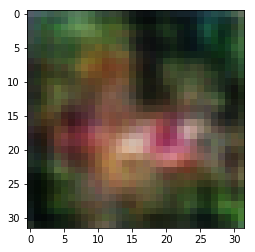

In [51]:
idx=0
plt.imshow(images.data.numpy()[idx].transpose((1,2,0))), CIFAR100_LABELS_LIST[cls_idx[idx].item()]

(<matplotlib.image.AxesImage at 0x7f17436fd208>, 'whale')

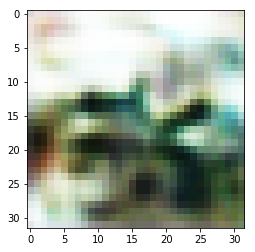

In [52]:
idx=1
plt.imshow(images.data.numpy()[idx].transpose((1,2,0))), CIFAR100_LABELS_LIST[cls_idx[idx].item()]

(<matplotlib.image.AxesImage at 0x7f1743653828>, 'couch')

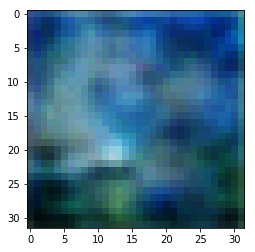

In [53]:
idx=2
plt.imshow(images.data.numpy()[idx].transpose((1,2,0))), CIFAR100_LABELS_LIST[cls_idx[idx].item()]

(<matplotlib.image.AxesImage at 0x7f174362ddd8>, 'chimpanzee')

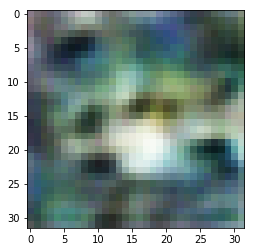

In [54]:
idx=3
plt.imshow(images.data.numpy()[idx].transpose((1,2,0))), CIFAR100_LABELS_LIST[cls_idx[idx].item()]

(<matplotlib.image.AxesImage at 0x7f174358c438>, 'mountain')

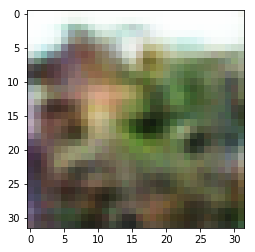

In [55]:
idx=4
plt.imshow(images.data.numpy()[idx].transpose((1,2,0))), CIFAR100_LABELS_LIST[cls_idx[idx].item()]

(<matplotlib.image.AxesImage at 0x7f17435659e8>, 'tank')

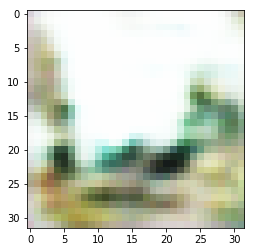

In [56]:
idx=5
plt.imshow(images.data.numpy()[idx].transpose((1,2,0))), CIFAR100_LABELS_LIST[cls_idx[idx].item()]

(<matplotlib.image.AxesImage at 0x7f174353dfd0>, 'elephant')

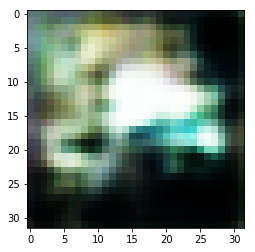

In [57]:
idx=6
plt.imshow(images.data.numpy()[idx].transpose((1,2,0))), CIFAR100_LABELS_LIST[cls_idx[idx].item()]

(<matplotlib.image.AxesImage at 0x7f17434996d8>, 'television')

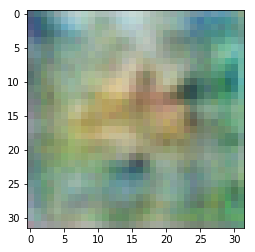

In [58]:
idx=7
plt.imshow(images.data.numpy()[idx].transpose((1,2,0))), CIFAR100_LABELS_LIST[cls_idx[idx].item()]

(<matplotlib.image.AxesImage at 0x7f174346fc18>, 'raccoon')

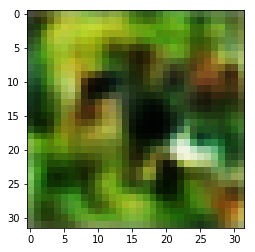

In [59]:
idx=8
plt.imshow(images.data.numpy()[idx].transpose((1,2,0))), CIFAR100_LABELS_LIST[cls_idx[idx].item()]